### Import modules

In [1]:
#import scikit-learn
from sklearn import mixture
from sklearn import preprocessing
from sklearn.decomposition import PCA
# import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib as mpl
# for label map
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# pyxpcm, xarray, dask
import numpy as np
import xarray as xr
import datetime as dt
import random
# import dask
from dask.distributed import Client
import dask

In [2]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='3GB')
client

Client Scheduler: tcp://127.0.0.1:51162 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 6.00 GB


### Subset parameters

In [3]:
# plotting subset
subset = range(1000,2000,1)

lon_min = -80
lon_max =  80
lat_min = -85
lat_max = -30

# depth range
zmin = 100.0
zmax = 900.0

### Import data

In [4]:
# ctds, floats, and seals
ctds = xr.open_mfdataset('../../../so-chic-data/CTD/*.nc', concat_dim='iPROF', combine='nested')
floats = xr.open_mfdataset('../../../so-chic-data/FLOATS/*.nc', concat_dim='iPROF', combine='nested')
seals = xr.open_mfdataset('../../../so-chic-data/SEALS/*.nc', concat_dim='iPROF', combine='nested')

# combine into single xarray.Dataset object
profiles = xr.combine_nested([ctds, floats, seals], concat_dim='iPROF')

# assign depth coordinate
profiles.coords['iDEPTH'] = profiles.prof_depth[0,:].values

# select subset of data between 0-1000 dbar
profiles = profiles.sel(iDEPTH=slice(zmin,zmax))

# rename some of the variables
profiles = profiles.rename({'iDEPTH':'depth',
                            'iPROF':'profile',
                            'prof_lon':'lon',
                            'prof_lat':'lat'})

# drop variables
profiles = profiles.drop_vars({'prof_depth'})

# change lon and lat to coordinates
profiles = profiles.set_coords({'lon','lat'})

# only keep a subset of the data variables
profiles = profiles.get(['prof_date','prof_YYYYMMDD','prof_HHMMSS','prof_T','prof_S'])

# select lat/lon section
profiles = profiles.where(profiles.lon<=lon_max,drop=True)
profiles = profiles.where(profiles.lon>=lon_min,drop=True)
profiles = profiles.where(profiles.lat<=lat_max,drop=True)
profiles = profiles.where(profiles.lat>=lat_min,drop=True)

# drop any remaining profiles with NaN values
# the profiles with NaN values likely don't have measurements in the selected depth range
profiles = profiles.dropna('profile')

# exameine Dataset
profiles

<xarray.Dataset>
Dimensions:        (depth: 15, profile: 185612)
Coordinates:
    lon            (profile) float64 dask.array<chunksize=(546,), meta=np.ndarray>
    lat            (profile) float64 dask.array<chunksize=(546,), meta=np.ndarray>
  * depth          (depth) float64 100.0 120.0 140.0 160.0 ... 640.0 730.0 820.0
Dimensions without coordinates: profile
Data variables:
    prof_date      (profile) float64 dask.array<chunksize=(546,), meta=np.ndarray>
    prof_YYYYMMDD  (profile) float64 dask.array<chunksize=(546,), meta=np.ndarray>
    prof_HHMMSS    (profile) float64 dask.array<chunksize=(546,), meta=np.ndarray>
    prof_T         (profile, depth) float64 dask.array<chunksize=(546, 15), meta=np.ndarray>
    prof_S         (profile, depth) float64 dask.array<chunksize=(546, 15), meta=np.ndarray>

### Time and date handling (currently broken)

In [5]:
# # select MITprof values
# ntime_array_ymd = profiles.prof_YYYYMMDD.values
# ntime_array_hms = profiles.prof_HHMMSS.values

# # select size
# nsize = ntime_array_ymd.size
# #nsize = 7

# # create array of zeros
# time = np.zeros((nsize,),dtype='datetime64[s]')

# # loop over all values, convert do datetime64[s]
# for i in range(0,nsize,1):
#     # extract strings for ymd and hms
#     s_ymd = str(ntime_array_ymd[i]).zfill(8)
#     s_hms = str(ntime_array_hms[i]).zfill(8)
#     # problem with 24:00:00
#     if s_hms=='240000.0':
#         s_hms = '235959.0'
#     # format into yyyy-mm-dd hh:mm:ss
#     date_str_ymd = s_ymd[0:4] + '-' + s_ymd[4:6] + '-' + s_ymd[6:8]
#     date_str_hms = s_hms[0:2] + ':' + s_hms[2:4] + ':' + s_hms[4:6]
#     date_str =  date_str_ymd + ' ' + date_str_hms
#     # convert to datetime64 (the 's' stands for seconds)
#     time[i] = np.datetime64(date_str,'s')
    
# # convert to pandas datetime (may not may not end up using this)
# #time_pd = pd.to_datetime(time)
    
# # convert time array into a DataArray
# da = xr.DataArray(time, dims=['profile'])

# # add DataArray as new data variable to DataSet
# profiles['time'] = da

# # set time as a coordinate
# profiles = profiles.set_coords('time')

# # examine Dataset again
# profiles

### Plot subset of profiles

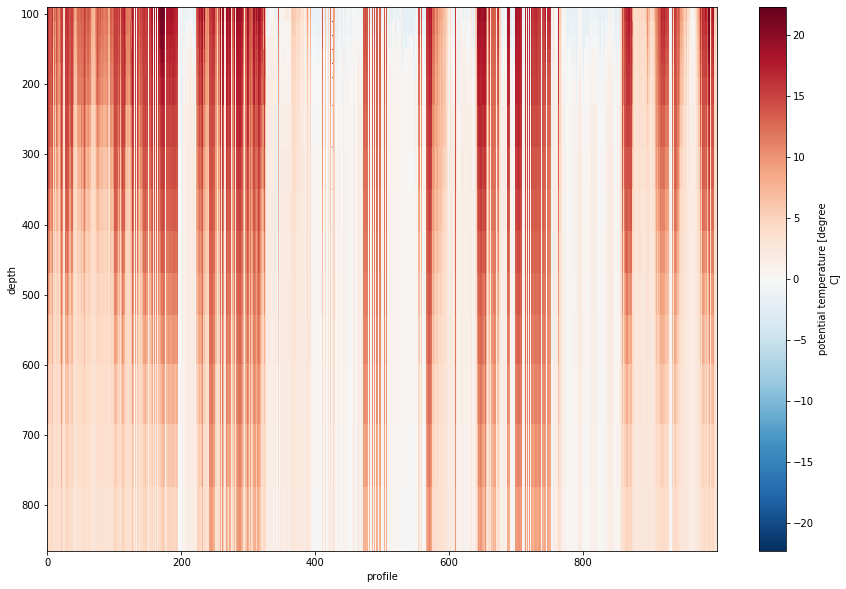

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
profiles.prof_T[subset].plot(y='depth', yincrease=False)

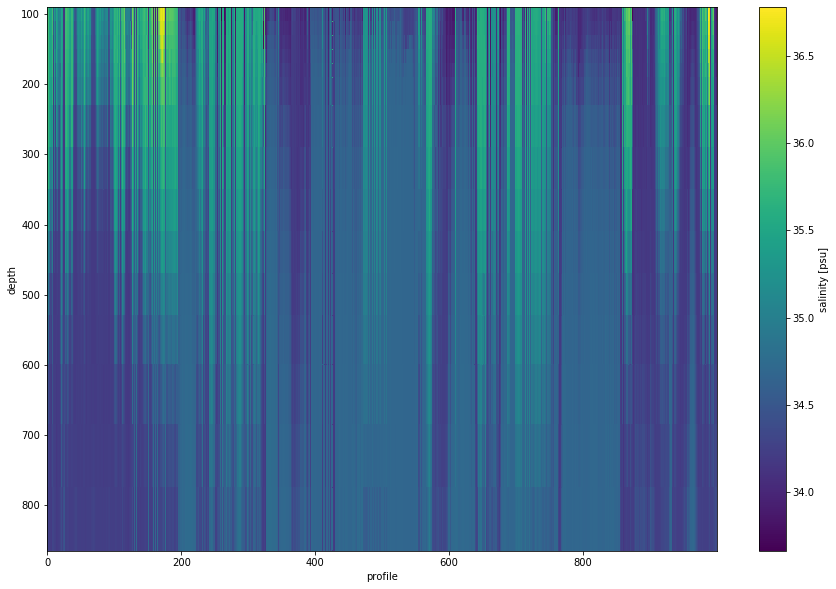

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
profiles.prof_S[subset].plot(y='depth', yincrease=False)

### Histograms to get a sense of the data distribution

(array([3.31094e+05, 9.17855e+05, 4.50864e+05, 2.47243e+05, 2.92072e+05,
        3.19577e+05, 1.88427e+05, 3.49050e+04, 2.08100e+03, 6.20000e+01]),
 array([-1.9605945 ,  0.8698903 ,  3.70037509,  6.53085988,  9.36134467,
        12.19182947, 15.02231426, 17.85279905, 20.68328384, 23.51376864,
        26.34425343]),
 <a list of 10 Patch objects>)

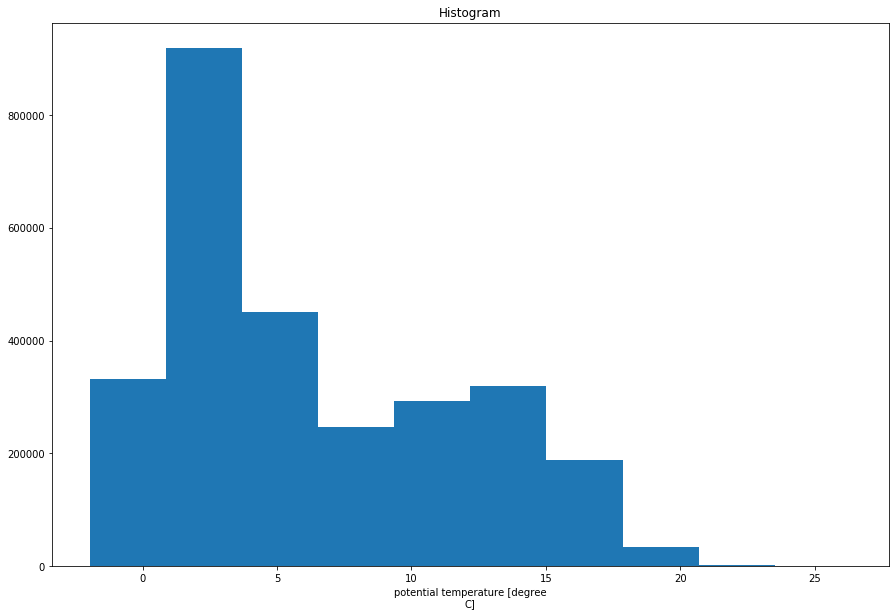

In [8]:
xr.plot.hist(profiles.prof_T,figsize=(15,10))

(array([2.84180e+04, 5.75468e+05, 8.92284e+05, 6.69577e+05, 2.91880e+05,
        2.83763e+05, 3.70670e+04, 4.70700e+03, 8.87000e+02, 1.29000e+02]),
 array([33.42644781, 33.80997736, 34.19350691, 34.57703646, 34.96056601,
        35.34409556, 35.7276251 , 36.11115465, 36.4946842 , 36.87821375,
        37.2617433 ]),
 <a list of 10 Patch objects>)

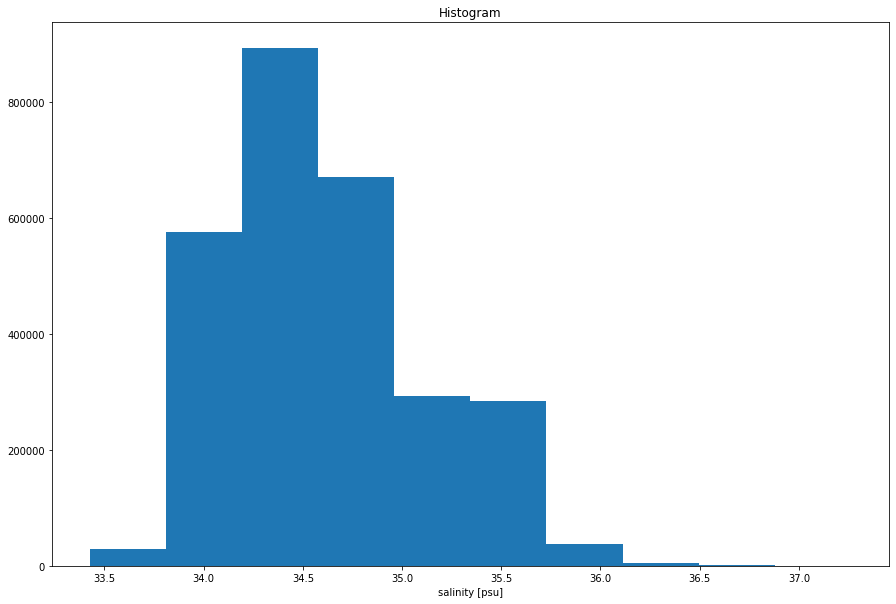

In [9]:
xr.plot.hist(profiles.prof_S,figsize=(15,10))

## Clustering attempt with GMM

In [10]:
# scale salinity
X = profiles.prof_S
scaled_S = preprocessing.scale(X)
scaled_S.shape

# scale temperature
X = profiles.prof_T
scaled_T = preprocessing.scale(X)
scaled_T.shape

# concatenate 
Xscaled = np.concatenate((scaled_T,scaled_S),axis=1)

# create PCA object
pca = PCA(n_components=3)

# fit PCA model
pca.fit(Xscaled)

# transform input data into PCA representation
Xpca = pca.transform(Xscaled)

# add PCA values to the profiles Dataset
PCA1 = xr.DataArray(Xpca[:,0],dims='profile')
PCA2 = xr.DataArray(Xpca[:,1],dims='profile')
PCA3 = xr.DataArray(Xpca[:,2],dims='profile')

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

0.9858584618007606

### Calculate BIC to inform selection of the number of clusters

In [11]:
# select parameters
max_N = 20     # the maximum number of classes to try 
max_bic_iter = 20  # the maximum number of iterations for BIC

# for the BIC step, try using a subset of the profiles
# you can change this 1000 value for different subsets
#Xpca_for_BIC = Xpca[::1000]

# initialise, declare variables
lowest_bic = np.infty
bic_scores = np.zeros((2,max_bic_iter))

# loop through the maximum number of classes, estimate BIC
n_components_range = range(2, max_N)
bic_iter_range = range(0,max_bic_iter)
# iterate through all the covariance types (just 'full' for now)
cv_types = ['full']
for cv_type in cv_types:
    # iterate over all the possible numbers of components
    for n_components in n_components_range:
        bic_one = []
        # repeat the BIC step for better statistics
        for bic_iter in bic_iter_range:
            # select a new random subset
            rows_id = random.sample(range(0,Xpca.shape[0]-1), 1000)
            Xpca_for_BIC = Xpca[rows_id,:]
            # fit a Gaussian mixture model
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type,
                                          random_state=42)

            # uncomment for 'rapid' BIC fitting
            gmm.fit(Xpca_for_BIC)
            # uncomment for 'full' BIC fitting
            #gmm.fit(Xpca)

            # append this BIC score to the list
            bic_one.append(gmm.bic(Xpca_for_BIC))
            Xpca_for_BIC = []

        # stack the bic scores into a single 2D structure
        bic_scores = np.vstack((bic_scores, np.asarray(bic_one)))

# the first two rows are not needed; they were only placeholders
bic_scores = bic_scores[2:,:]

# mean values for BIC
bic_mean = np.mean(bic_scores, axis=1)

# standard deviation for BIC
bic_std = np.std(bic_scores, axis=1)

# examine the mean bic values
#bic_mean

### Plot the BIC scores

Text(0, 0.5, 'BIC score')

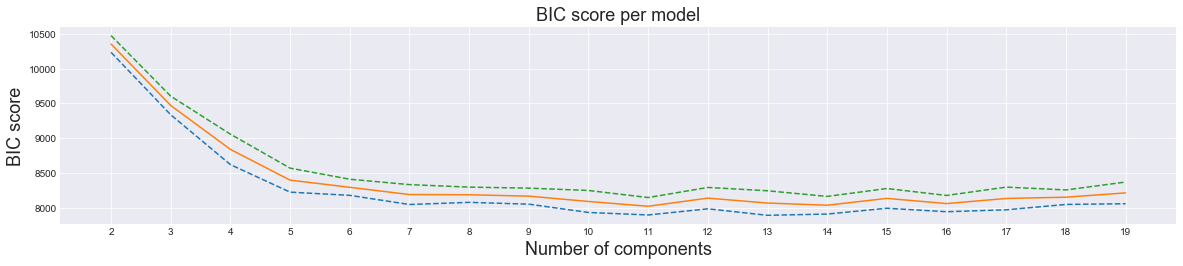

In [12]:
# plot the BIC scores
plt.figure(figsize=(20, 8))
plt.style.use('seaborn-darkgrid')
spl = plt.subplot(2, 1, 1)
plt.plot(n_components_range, bic_mean-bic_std, '--')  
plt.plot(n_components_range, bic_mean, '-')  
plt.plot(n_components_range, bic_mean+bic_std, '--')  
plt.xticks(n_components_range)
#plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model', fontsize=18)
spl.set_xlabel('Number of components',fontsize=18)
spl.set_ylabel('BIC score',fontsize=18)
#plt.show()

### Select the actual GMM to be used in the analysis

In [13]:
# set variables
n_components_selected = 5

# establish gmm
best_gmm = mixture.GaussianMixture(n_components=n_components_selected,
                                   covariance_type='full',
                                   random_state=42)

# fit this GMM
best_gmm.fit(Xpca)

# check to make sure that n_comp is as expected
n_comp = gmm.n_components

# select colormap
colormap = plt.get_cmap('tab10', n_comp)

# assign class labels ("predict" the class using the selected GMM)
labels = best_gmm.predict(Xpca)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs = best_gmm.predict_proba(Xpca)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs = np.max(posterior_probs,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
#df.insert(3,'label',labels,True)
#df.insert(4,'max posterior prob',max_posterior_probs,True) 

# print out best_gmm parameters
#posterior_probs.shape

# convert labels into xarray format
xlabels = xr.DataArray(labels, coords=[profiles.profile], dims='profile')

# convert posterior probabilities into xarray format
gmm_classes = [b for b in range(0,n_components_selected,1)]
xprobs = xr.DataArray(posterior_probs, 
                      coords=[profiles.profile, gmm_classes], 
                      dims=['profile', 'CLASS'])

# add label DataArray to Dataset
profiles = profiles.assign({'label':xlabels})
profiles = profiles.assign({'posteriors':xprobs})

### Visualise clustering in PC space

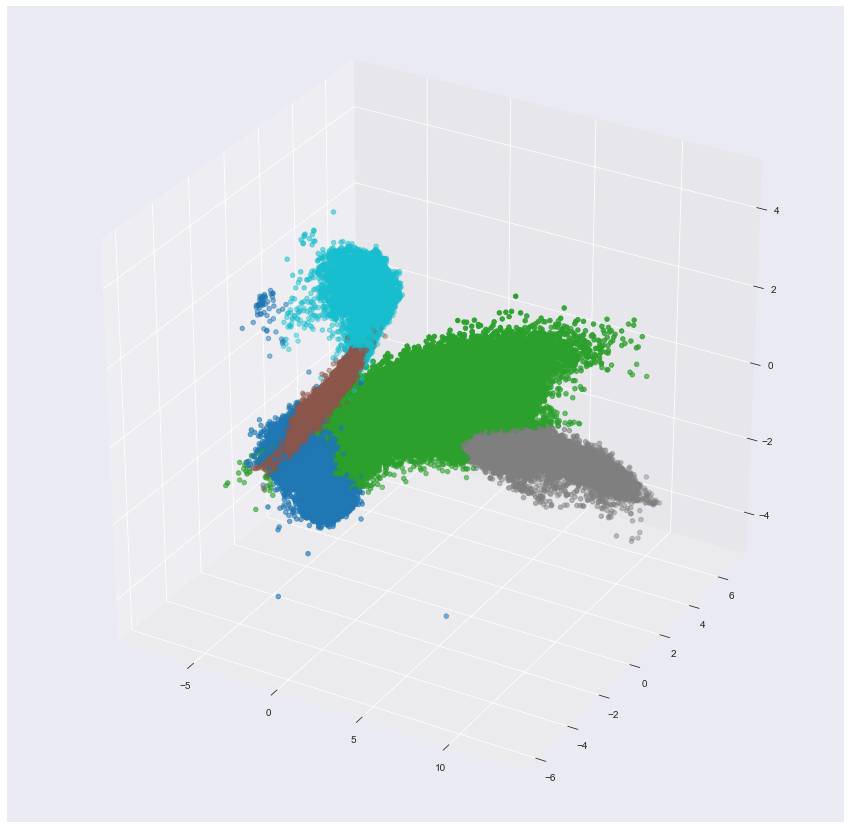

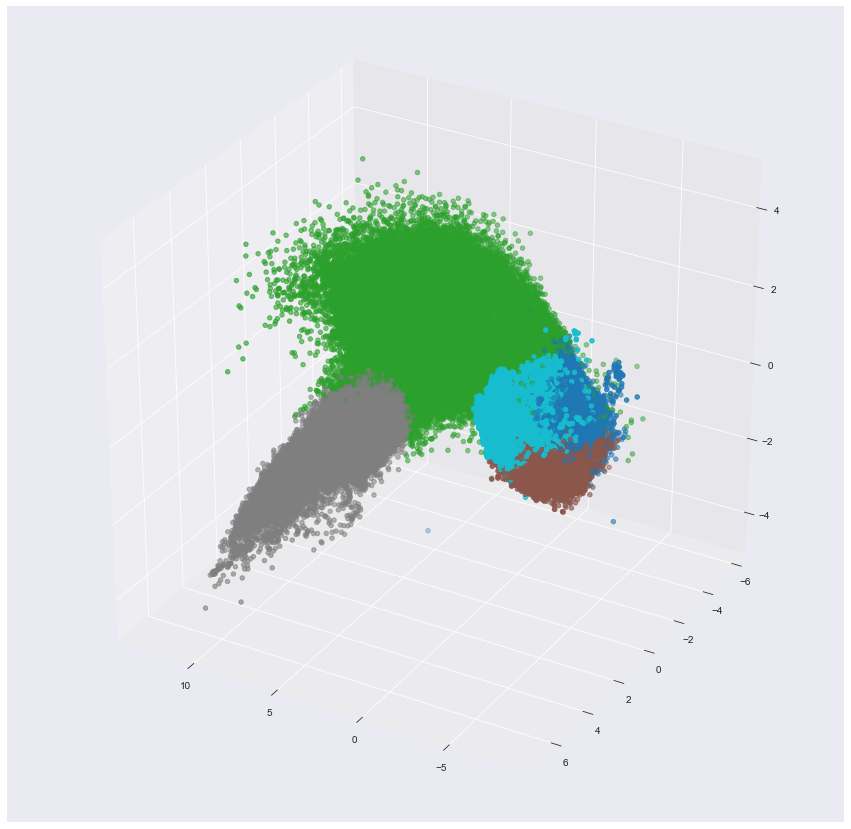

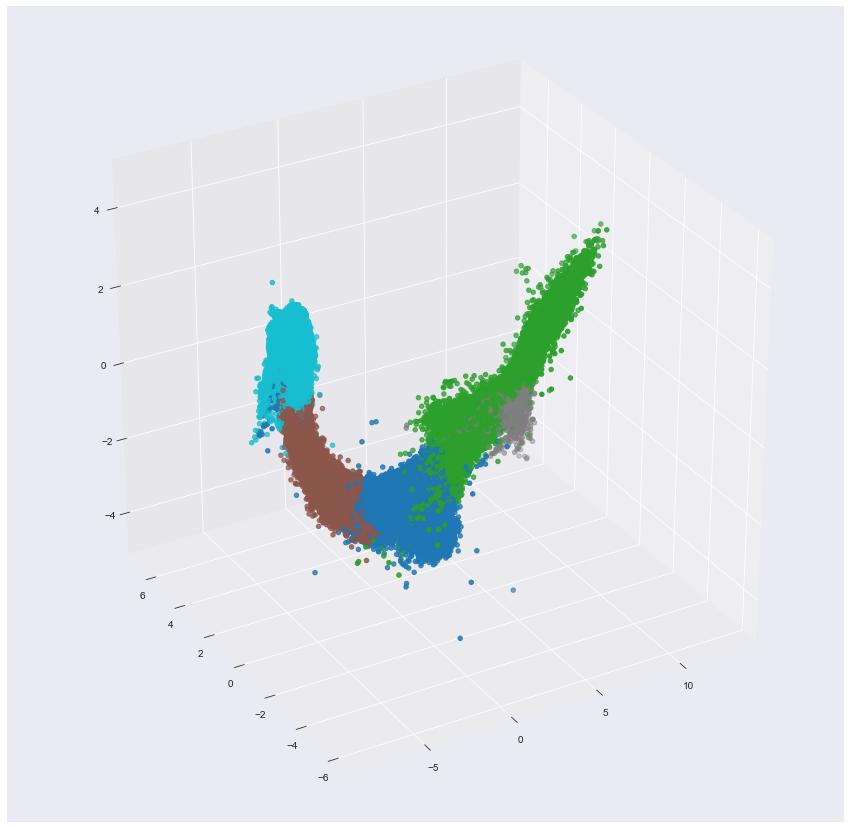

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import seaborn as sns

# initial view
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(PCA1.values, PCA2.values, PCA3.values, c=labels, cmap=cm.tab10)

# new view
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.view_init(30, 120)
ax.scatter(PCA1.values, PCA2.values, PCA3.values, c=labels, cmap=cm.tab10)

# new view
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.view_init(30, 240)
ax.scatter(PCA1.values, PCA2.values, PCA3.values, c=labels, cmap=cm.tab10)


### Calculate class means and standard deviations

In [15]:
# create grouped object using the labels
grouped = profiles.groupby("label")

# class means and standard deviations
class_means = grouped.mean()
class_stds = grouped.std()

# visualize grouped dataset
#class_means

### Plot vertical T and S structure of the classes

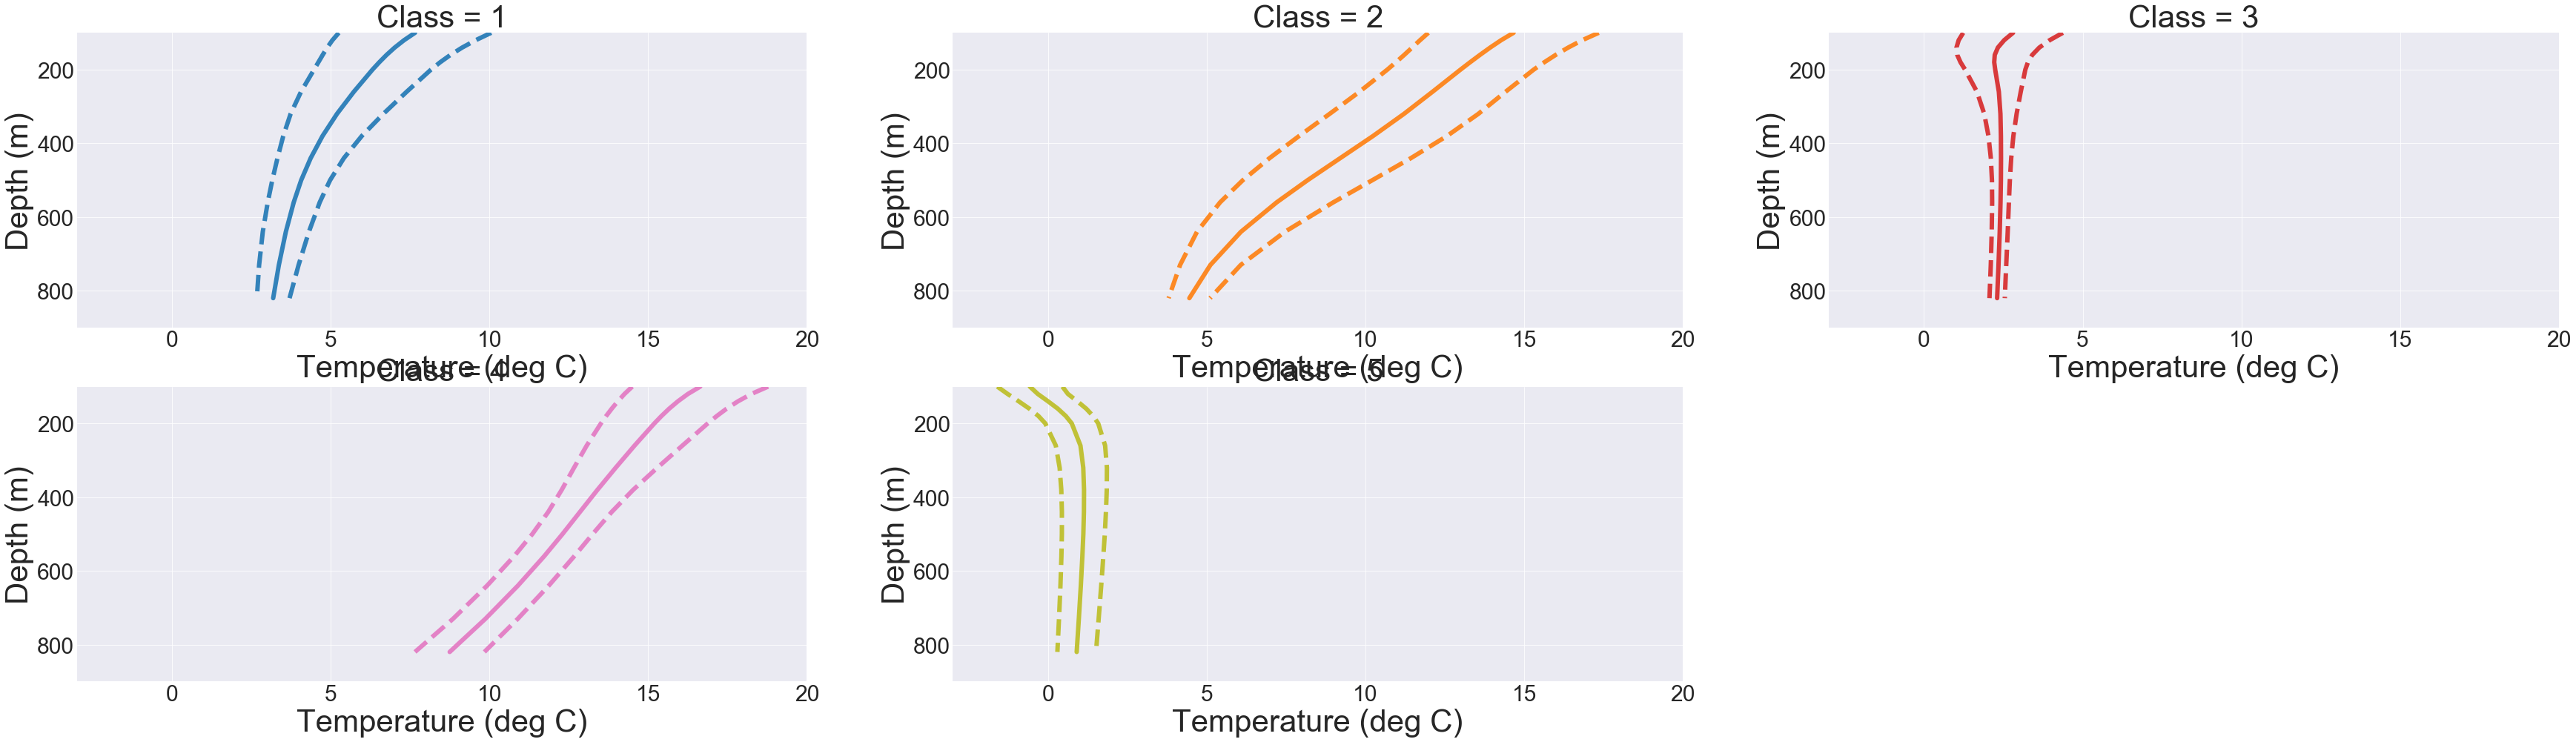

In [16]:
cNorm = colors.Normalize(vmin=0, vmax=n_components_selected)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# vertical coordinate
z = profiles.depth.values    
    
# iterate over groups
num = 0
for nrow in range(0,n_components_selected):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
    
    # extract means
    mean_T = class_means.prof_T[nrow,:].values
    
    # extract stdevs
    std_T = class_stds.prof_T[nrow,:].values
    
    # select subplot
    ax = plt.subplot(np.ceil(n_comp/3),3,num)
    plt.plot(mean_T, z, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T+std_T, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T-std_T, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    plt.ylim([zmin,zmax])
    plt.xlim([-3, 20])
    
   #text box
    fs = 42 # font size
    plt.xlabel('Temperature (deg C)', fontsize=fs)
    plt.ylabel('Depth (m)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    
    # font and axis stuff
    plt.gca().invert_yaxis()
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)

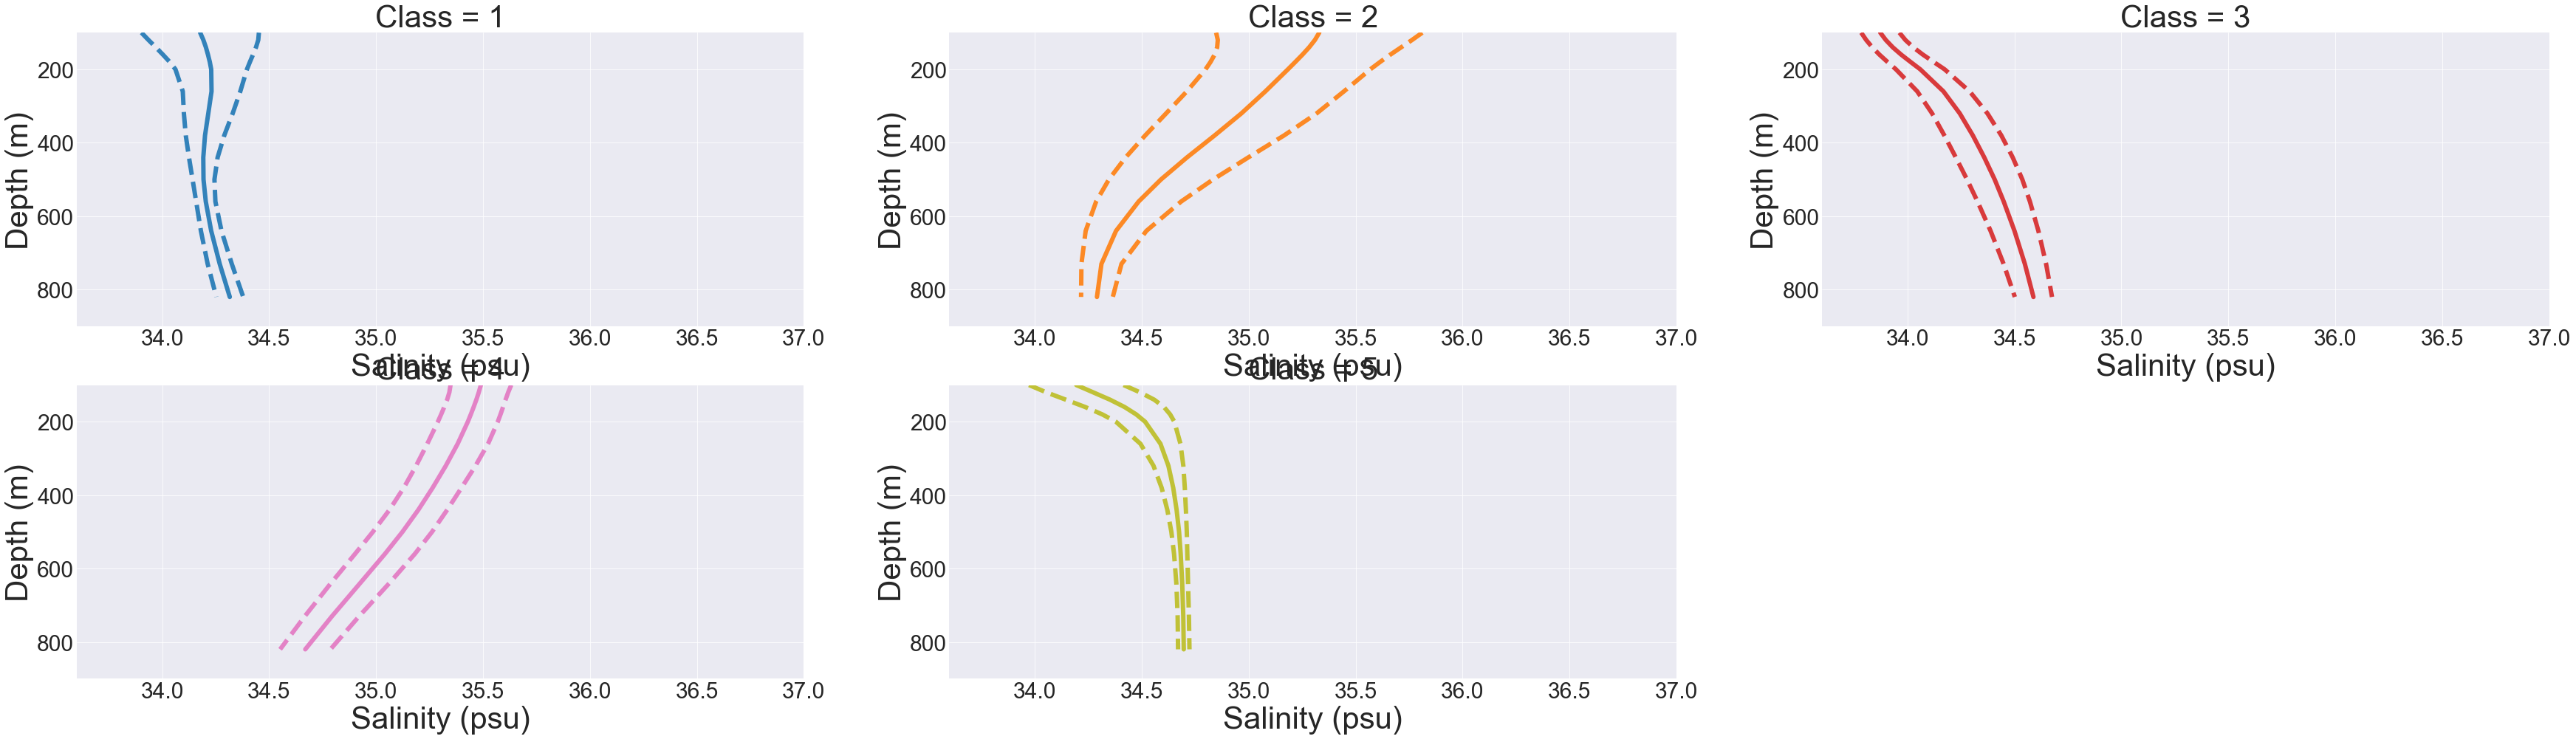

In [17]:
cNorm = colors.Normalize(vmin=0, vmax=n_components_selected)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# vertical coordinate
z = profiles.depth.values    
    
# iterate over groups
num = 0
for nrow in range(0,n_components_selected):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
    
    # extract means
    mean_S = class_means.prof_S[nrow,:].values
    
    # extract stdevs
    std_S = class_stds.prof_S[nrow,:].values
    
    # select subplot
    ax = plt.subplot(np.ceil(n_comp/3),3,num)
    plt.plot(mean_S, z, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_S+std_S, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_S-std_S, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    plt.ylim([zmin, zmax])
    plt.xlim([33.6, 37.0])
    
   #text box
    fs = 42 # font size
    plt.xlabel('Salinity (psu)', fontsize=fs)
    plt.ylabel('Depth (m)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    
    # font and axis stuff
    plt.gca().invert_yaxis()
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
   

### Label map of the classes

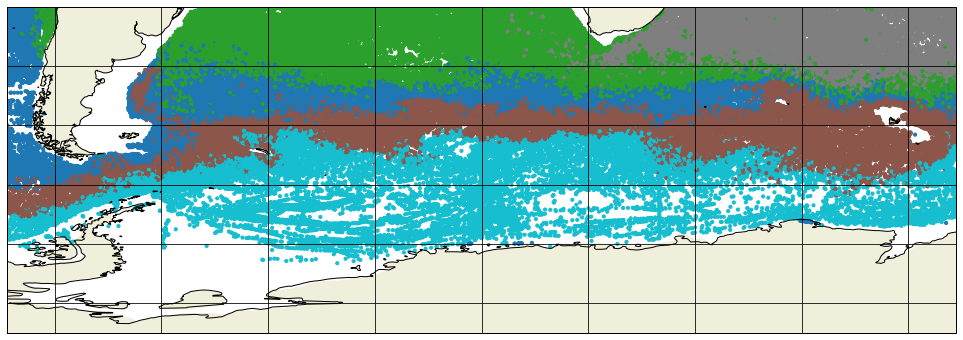

In [18]:
# extract values as new DataArrays
df1D = profiles.isel(depth=0)
da_lon = df1D.lon
da_lat = df1D.lat
da_label = df1D.label

# extract values
lons = da_lon.values
lats = da_lat.values
clabels = da_label.values

# size of random sample
random_sample_size = int(np.ceil(0.30*df1D.profile.size))

# random sample for plotting
rows_id = random.sample(range(0,clabels.size-1), random_sample_size)
lons_random_sample = lons[rows_id]
lats_random_sample = lats[rows_id]
clabels_random_sample = clabels[rows_id]

#colormap with Historical data
plt.figure(figsize=(17, 13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
CS = plt.scatter(lons_random_sample-360, 
                 lats_random_sample, 
                 c=clabels_random_sample,
                 marker='o',
                 cmap= colormap,
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)

### Calculate the i-metric 
https://os.copernicus.org/preprints/os-2021-40/

In [19]:
# function to calculate the i_metric, label, and runner-up label
def get_i_metric(posterior_prob_list):
    sorted_posterior_list = sorted(posterior_prob_list)
    ic_metric = 1 - (sorted_posterior_list[-1] - sorted_posterior_list[-2])
    runner_up_label = posterior_prob_list.index(sorted_posterior_list[-2])
    label = posterior_prob_list.index(sorted_posterior_list[-1])
    return ic_metric, np.array([label, runner_up_label]) # np.sort()

#### Loop through profiles (this may take a few minutes)

In [20]:
# declare variables 
i_metric = np.zeros(df1D.profile.size)
a_b = np.zeros((df1D.profile.size,2))

# loop through the profiles, calculate the i_metric for each one
for i in range(df1D.profile.size):
      i_metric[i], a_b[i,:] = get_i_metric(df1D.posteriors[i, :].values.tolist())

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:51237 remote=tcp://127.0.0.1:51162>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:51277 remote=tcp://127.0.0.1:51162>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:51304 remote=tcp://127.0.0.1:51162>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:51310 remote=tcp://127.0.0.1:51162>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:51312 remote=tcp://127.0.0.1:51162>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:51321 remote=tcp://127.0.0.1:51162>


In [21]:
# convert i_metric numpy array to xarray DataArray
i_metric = xr.DataArray(i_metric, coords=[profiles.profile], dims='profile')

# add i_metric DataArray to Dataset
df1D = df1D.assign({'i_metric':i_metric})

### Plot i-metric map

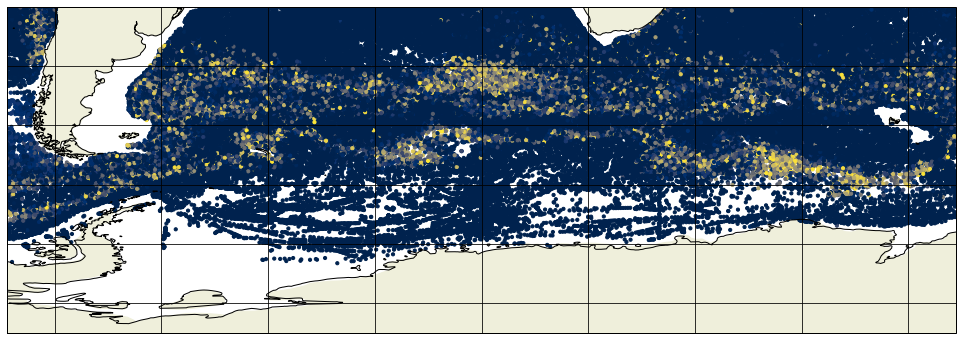

In [22]:
# extract values as new DataArrays
da_lon = df1D.lon
da_lat = df1D.lat
da_i_metric = df1D.i_metric

# extract values
lons = da_lon.values
lats = da_lat.values
c = da_i_metric.values

# random sample for plotting
rows_id = random.sample(range(0,c.size-1), random_sample_size)
lons_random_sample = lons[rows_id]
lats_random_sample = lats[rows_id]
clabels_random_sample = c[rows_id]

#colormap with Historical data
plt.figure(figsize=(17, 13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
CS = plt.scatter(lons_random_sample-360, 
                 lats_random_sample, 
                 c=clabels_random_sample,
                 marker='o',
                 cmap= plt.get_cmap('cividis'),
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)

### Plot i-metric by class

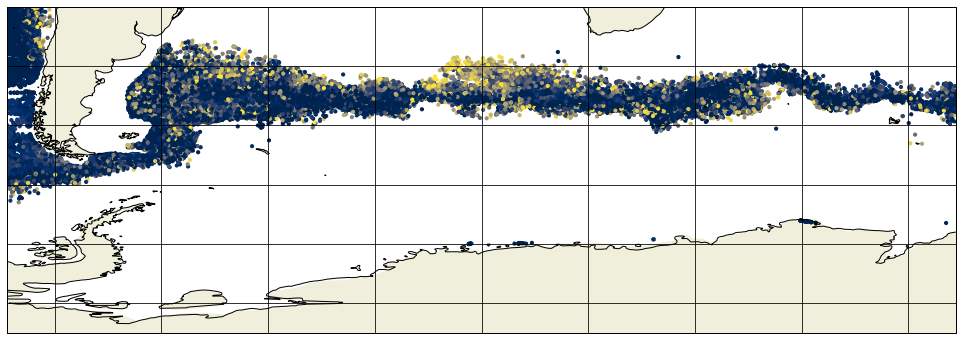

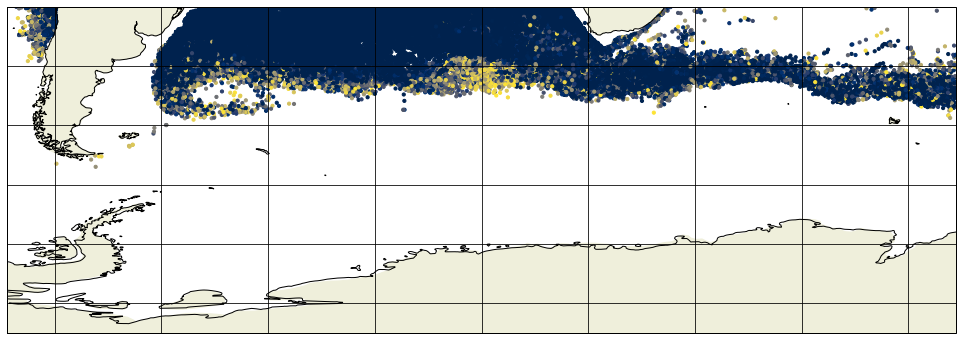

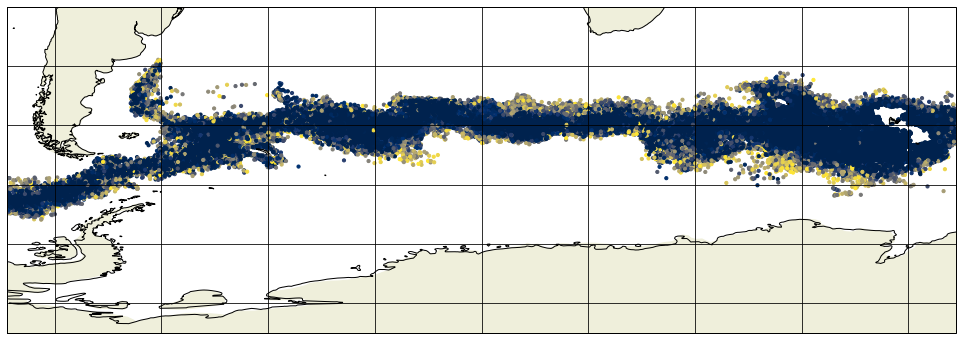

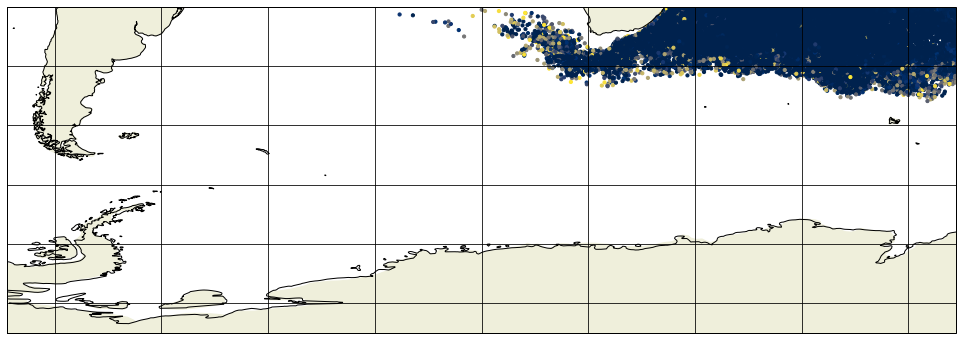

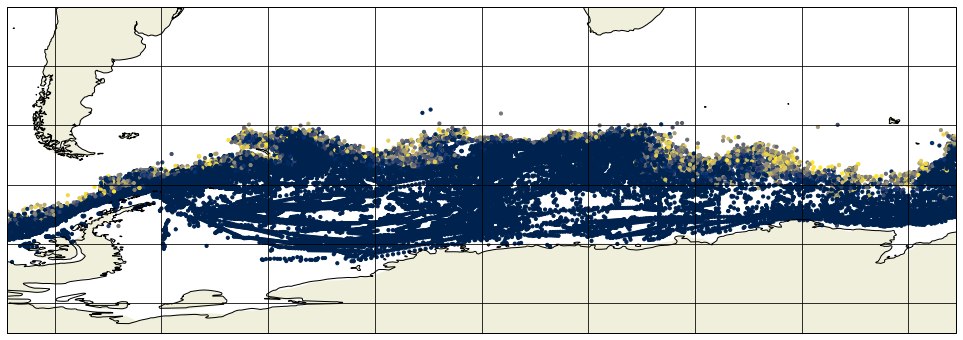

In [23]:
# extract values as new DataArrays
da_lon = df1D.lon
da_lat = df1D.lat
da_i_metric = df1D.i_metric

# extract values
lons = da_lon.values
lats = da_lat.values
c = da_i_metric.values

for iclass in range(n_components_selected):

    # random sample for plotting
    lons_random_sample = lons[labels==iclass]
    lats_random_sample = lats[labels==iclass]
    clabels_random_sample = c[labels==iclass]

    #colormap with Historical data
    plt.figure(figsize=(17, 13))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-80, 80, -85, -30], ccrs.PlateCarree())
    CS = plt.scatter(lons_random_sample-360, 
                     lats_random_sample, 
                     c=clabels_random_sample,
                     marker='o',
                     cmap= plt.get_cmap('cividis'),
                     s=10.0,
                     transform=ccrs.Geodetic(),
                     )
    ax.coastlines(resolution='50m')
    ax.gridlines(color='black')
    ax.add_feature(cartopy.feature.LAND)